In [1]:
import numpy as np, matplotlib.pyplot as plt, matplotlib as mpl
import pcmdpy as ppy
from astropy.io import fits
from scipy.misc import face
from scipy.signal import gaussian
import seaborn.apionly as sns
plt.style.use('seaborn-poster')
mpl.rcParams['image.origin'] = 'lower'
%matplotlib inline

GPU acceleration enabled
using given n: 0
Starting SourceModule Code
Past the SourceModule code
CUDAC Available


In [2]:
mpl.rcParams['image.aspect'] = 'auto'
mpl.rcParams['image.interpolation'] = 'None'


In [3]:
f_m31 = ppy.instrument.default_m31_filters()
f_m49 = ppy.instrument.default_m49_filters()

In [45]:
for f_ in f_m49:
    f_._exposure *= 2.

In [46]:
iso_m31 = ppy.isochrones.Isochrone_Model(f_m31)
iso_m49 = ppy.isochrones.Isochrone_Model(f_m49)

In [47]:
driv_m31 = ppy.driver.Driver(iso_m31)
driv_m49 = ppy.driver.Driver(iso_m49)

In [48]:
gal_m31 = ppy.galaxy.TauFull(np.array([0., -2., 2.3, 1.0, 24.47]))
gal_m49 = ppy.galaxy.TauFull(np.array([0., -2., 5.2, 1.0, 31.3]))


In [49]:
sim_m31 = driv_m31.simulate(gal_m31, 256, mag_system='ab')[1]
sim_m49 = driv_m49.simulate(gal_m49, 256)[1]


In [131]:
driv_m31.filters = ppy.instrument.m31_narrow_psf()

In [132]:
sim_m31_narrow = driv_m31.simulate(gal_m31, 256, mag_system='ab')[1]

In [39]:
def gaussian_psf(sig, scale=70):
    kernel = np.outer(gaussian(scale, sig), gaussian(scale, sig))
    return kernel / np.sum(kernel)

In [40]:
def gauss_convolve(im, sig, scale=70):
    f._psf = gaussian_psf(sig, scale=scale)
    return f.psf_convolve(im, multi_psf=False)

In [10]:
def empirical_convolve(im):
    f = ppy.instrument.ACS_WFC_F814W()
    return f.psf_convolve(im, multi_psf=False)

In [157]:
def spatial_correlation(im, a=10):
    nx, ny = im.shape
    im_p = np.fft.fft2(im)
    corr = np.fft.ifft2(im_p * np.conjugate(im_p)).real
    corr /= corr.mean()
    corr -= 1.
    corr = np.roll(np.roll(corr, ny//2, axis=-1), nx//2, axis=-2)
    corr =  corr[(nx//2)-a:(nx//2)+a+1,(ny//2)-a:(ny//2)+a+1]
    Y = np.arange(-a, a+1).repeat(2*a + 1).reshape((2*a+1, 2*a+1))
    X = Y.T
    R = np.sqrt(X**2 + Y**2)
    sort_idx = R.flatten().argsort()
    r = R.flatten()[sort_idx]
    c = corr.flatten()[sort_idx]
    return corr, r, c

In [158]:
def show_corr(corr_im, ax=None, norm=None):
    if ax is None:
        fig, ax = plt.subplots()
    if norm is None:
        norm = mpl.colors.Normalize()
    ax.imshow(corr_im, interpolation='None', aspect='auto', norm=norm)
    return ax

In [159]:
m31 = fits.open('../data/m31/raw/bulge_tiny_both.fits')
m49_raw = fits.open('../data/m49/raw/oneexp_tiny_both.fits')
m49_drz = fits.open('../data/m49/raw/drizzled_tiny_both.fits')

In [160]:
m31_f475w = m31['sci,1'].data
m31_f814w = m31['sci,2'].data

Text(0.5,1,'Simulated')

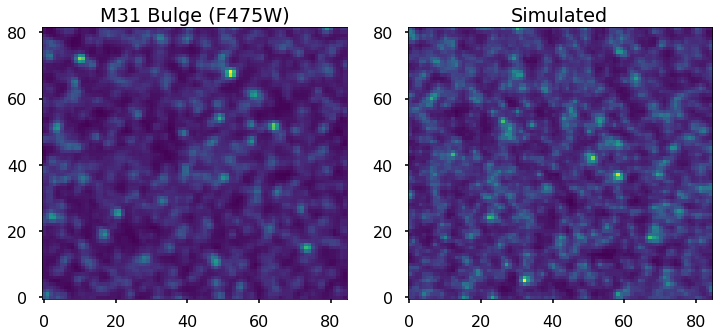

In [161]:
fig, axes = plt.subplots(ncols=2, figsize=(12,5))
axes[0].imshow(m31_f475w)
axes[1].imshow(sim_m31[1][:m31_f475w.shape[0], :m31_f475w.shape[1]])
axes[0].set_title('M31 Bulge (F475W)')
axes[1].set_title('Simulated')

In [162]:
m49_f475w_raw = m49_raw['sci,1'].data
m49_f850lp_raw = m49_raw['sci,2'].data
m49_f475w_raw[np.isnan(m49_f475w_raw)] = -1.
m49_f850lp_raw[np.isnan(m49_f850lp_raw)] = -1.

In [163]:
m49_f475w_drz = m49_drz['sci,1'].data * f_m49[1]._exposure
m49_f850lp_drz = m49_drz['sci,2'].data * f_m49[0]._exposure

Text(0.5,1,'Simulated')

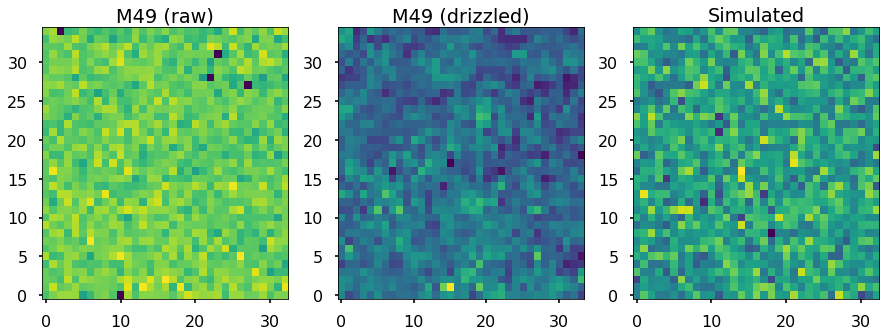

In [164]:
fig, axes = plt.subplots(ncols=3, figsize=(15,5))
axes[0].imshow(m49_f475w_raw)
axes[1].imshow(m49_f475w_drz)
axes[2].imshow(sim_m49[1][:m49_f475w_raw.shape[0], :m49_f475w_raw.shape[1]])
axes[0].set_title('M49 (raw)')
axes[1].set_title('M49 (drizzled)')
axes[2].set_title('Simulated')

In [165]:
corrs, xs, ys = {}, {}, {}

In [166]:
ims = {
    'm31_f475w_drz': m31_f475w,
    'm31_f814w_drz': m31_f814w,
    'm31_f475w_sim': sim_m31[1],
    'm31_f814w_sim': sim_m31[0],
    'm31_f475w_sim_narrow': sim_m31_narrow[1],
    'm31_f814w_sim_narrow': sim_m31_narrow[0],
    'm49_f475w_raw': m49_f475w_raw,
    'm49_f475w_drz': m49_f475w_drz,
    'm49_f475w_sim': sim_m49[1],
    'm49_f850lp_raw': m49_f850lp_raw,
    'm49_f850lp_drz': m49_f850lp_drz,
    'm49_f850lp_sim': sim_m49[0],
}

In [167]:
for name, im in ims.items():
    im /= im.mean()
    corrs[name], xs[name], ys[name] = spatial_correlation(im, a=10)

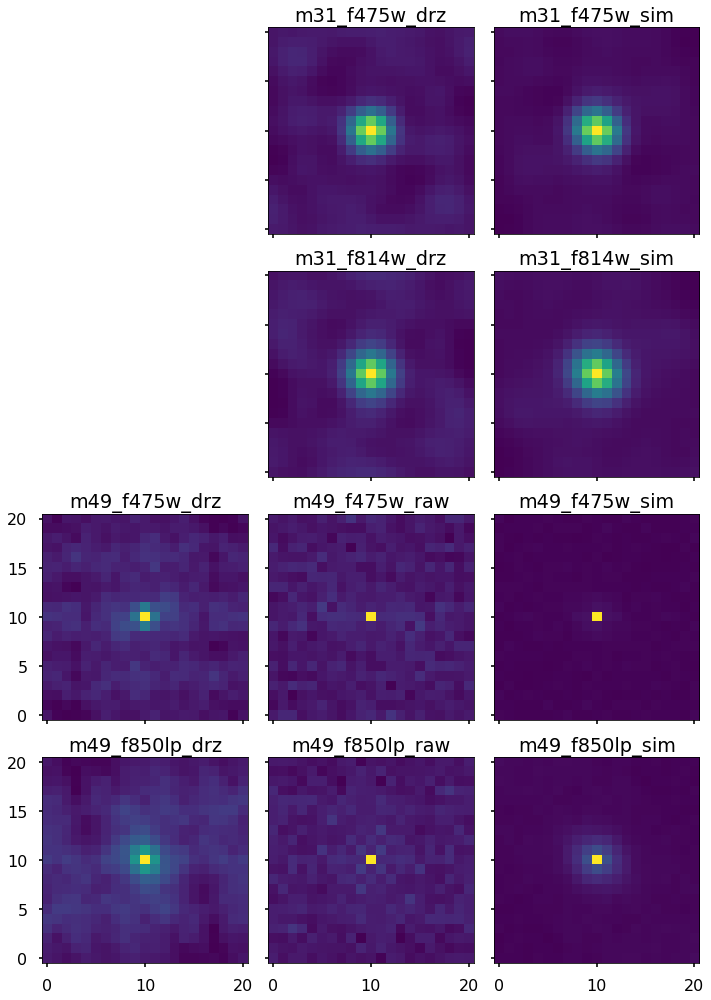

In [168]:
fig, axes = plt.subplots(ncols=3, nrows=4, figsize=(10, 14), sharex=True, sharey=True)
for a, n in zip(axes[0][1:], ['m31_f475w_drz', 'm31_f475w_sim']):
    norm = mpl.colors.Normalize()
    show_corr(corrs[n], ax=a, norm=norm)
    a.set_title(n)
axes[0,0].axis('off')

for a, n in zip(axes[1][1:], ['m31_f814w_drz', 'm31_f814w_sim']):
    norm = mpl.colors.Normalize()
    show_corr(corrs[n], ax=a, norm=norm)
    a.set_title(n)
axes[1,0].axis('off')

for a, n in zip(axes[2], ['m49_f475w_drz', 'm49_f475w_raw', 'm49_f475w_sim']):
    norm = mpl.colors.Normalize()
    show_corr(corrs[n], ax=a, norm=norm)
    a.set_title(n)

for a, n in zip(axes[3], ['m49_f850lp_drz', 'm49_f850lp_raw', 'm49_f850lp_sim']):
    norm = mpl.colors.Normalize()
    show_corr(corrs[n], ax=a, norm=norm)
    a.set_title(n)

plt.tight_layout()

In [169]:
palette = sns.color_palette('colorblind')

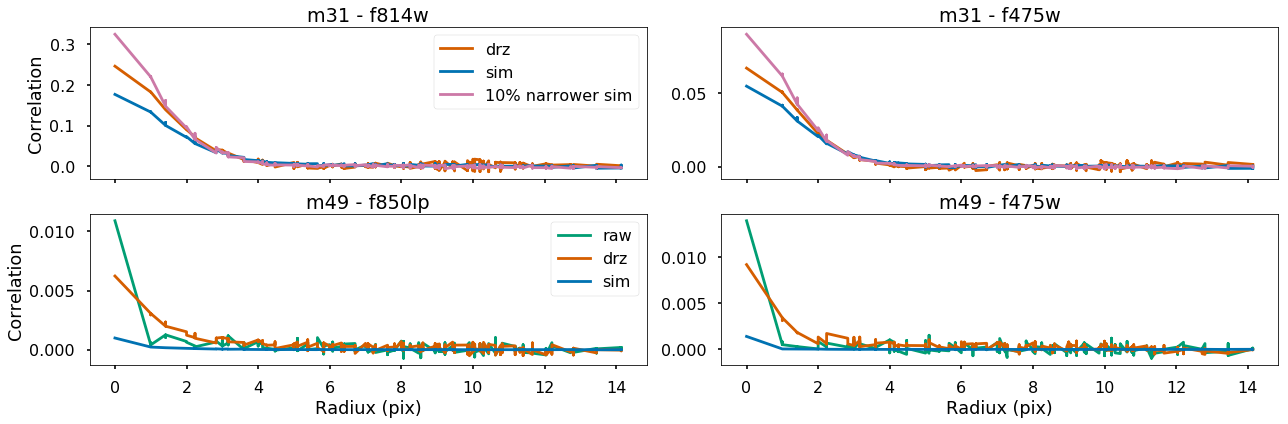

In [171]:
fig, axes = plt.subplots(ncols=2, nrows=2, figsize=(18, 6), sharex=True)
for n in xs.keys():
    if 'm31' in n:
        if 'f814w' in n:
            ax = axes[0,0]
        else:
            ax = axes[0,1]
    else:
        if 'f850lp' in n:
            ax = axes[1,0]
        else:
            ax = axes[1,1]
    if 'narrow' in n:
        label='10% narrower sim'
        color = palette[3]
    elif 'sim' in n:
        label = 'sim'
        color= palette[0]
    elif 'raw' in n:
        label = 'raw'
        color = palette[1]
    else:
        label = 'drz'
        color = palette[2]
    ax.plot(xs[n], ys[n], label=label, color=color)
axes[0,0].set_title('m31 - f814w')
axes[0,1].set_title('m31 - f475w')
axes[1,0].set_title('m49 - f850lp')
axes[1,1].set_title('m49 - f475w')
axes[1,0].legend(loc=0)
axes[0,0].legend(loc=0)
for a in axes[1]:
    a.set_xlabel('Radiux (pix)')
for a in axes[:,0]:
    a.set_ylabel('Correlation')
plt.tight_layout()